### <b>AirBnB Fair Valuation<br></b>

Our task is to set the competitive daily accomodation rate for a client's house. We have been tasked to estimate a fair value that the owner should be charging the customers.

### Business objectives and constraints:<br>
1) Cost of our mistakes in prediction: Customer or the tenant will gain/lose money. So minimal errors are needed.<br>
2) No low latency requirement, our model can take a few seconds (10-30) to give prediction.<br>
3) An interpretable model would be good, but here, the accuracy of prediction would be our preference, so a little complex model would not be a bad choice.

### Evaluation:<br>
We will use RMSE (root mean squared error), MAE (mean absolute error) and R-squared to evaluate our results.


<br>

### Importing important libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import re
import nltk
from statistics import median, mode

from wordcloud import WordCloud, STOPWORDS

np.random.seed(100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

 
 <br>

### Importing the data:

In [2]:
data = pd.read_csv('airbnb.csv')
data.drop(columns=['Unnamed: 0', 'experiences_offered', 'neighbourhood'], inplace=True)
print(data.shape)
data.head()

(24725, 32)


,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price
0,12351,f,2.0,t,Pyrmont,-33.865153,151.191896,t,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,This was my first Airbnb experience and I am h...,f,10.0,10.0,10.0,10.0,9.0,10.0,95.0,493,187,7,2,$395.00,$55.00,$0.00,$100.00
1,14250,f,2.0,t,Balgowlah,-33.800929,151.261722,t,House,Entire home/apt,6,3.0,3.0,3.0,Real Bed,We did not meet Heidi but she was very friendl...,f,10.0,10.0,8.0,10.0,10.0,10.0,100.0,1,321,22,5,$40.00,$100.00,$900.00,$471.00
2,15253,f,2.0,t,Darlinghurst,-33.880455,151.216541,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,Morag is a helpful easy going host.\r\nHer pla...,t,9.0,9.0,9.0,9.0,9.0,9.0,88.0,300,316,7,2,$10.00,NaN,NaN,$109.00
3,20865,t,2.0,t,Balmain,-33.859072,151.172753,t,House,Entire home/apt,8,2.0,4.0,4.0,Real Bed,Still travelling so a little late in our revie...,f,9.0,10.0,10.0,9.0,9.0,9.0,96.0,15,69,365,7,$0.00,NaN,$800.00,$450.00
4,26174,f,1.0,t,Bellevue Hill,-33.889087,151.259404,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"Great host, very friendly and accomodating. Ap...",f,9.0,10.0,10.0,10.0,10.0,10.0,94.0,42,140,60,1,$15.00,$25.00,$0.00,$62.00


 
 <br>

### Checking abnormalities in data:

In [3]:
data.isna().sum()/len(data)

id                             0.000000
host_is_superhost              0.000081
host_total_listings_count      0.000081
host_identity_verified         0.000081
city                           0.000647
latitude                       0.000000
longitude                      0.000000
is_location_exact              0.000000
property_type                  0.000000
room_type                      0.000000
accommodates                   0.000000
bathrooms                      0.000526
bedrooms                       0.000162
beds                           0.000647
bed_type                       0.000000
reviews_clubbed                0.000081
instant_bookable               0.000000
review_scores_value            0.050961
review_scores_location         0.050839
review_scores_communication    0.049343
review_scores_checkin          0.050799
review_scores_cleanliness      0.049100
review_scores_accuracy         0.049909
review_scores_rating           0.048089
number_of_reviews              0.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24725 entries, 0 to 24724
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           24725 non-null  int64  
 1   host_is_superhost            24723 non-null  object 
 2   host_total_listings_count    24723 non-null  float64
 3   host_identity_verified       24723 non-null  object 
 4   city                         24709 non-null  object 
 5   latitude                     24725 non-null  float64
 6   longitude                    24725 non-null  float64
 7   is_location_exact            24725 non-null  object 
 8   property_type                24725 non-null  object 
 9   room_type                    24725 non-null  object 
 10  accommodates                 24725 non-null  int64  
 11  bathrooms                    24712 non-null  float64
 12  bedrooms                     24721 non-null  float64
 13  beds            

<b>===Presence of a foriegn language===

In [5]:
## Checking 1st data point:

for i,j in zip(data.values[0], data.columns):
    print(j,' :-')
    print(i)
    print('='*90)

id  :-
12351
host_is_superhost  :-
f
host_total_listings_count  :-
2.0
host_identity_verified  :-
t
city  :-
Pyrmont
latitude  :-
-33.86515254975741
longitude  :-
151.19189588780822
is_location_exact  :-
t
property_type  :-
Townhouse
room_type  :-
Private room
accommodates  :-
2
bathrooms  :-
1.0
bedrooms  :-
1.0
beds  :-
1.0
bed_type  :-
Real Bed
reviews_clubbed  :-
This was my first Airbnb experience and I am hooked! these guys are glorious . The most gracious hosts with generous hearts. Of course they do have many years experience running a BnB in Mudgie so they know the drill but that aside , they were welcoming, friendly, and forthcoming. I don't know Sydney and they do - which was they main reason I wanted to stay with an airbnb host. This is a great way to beat the lonely hotel blues, a great way to get that 'in' on local knowledge. A lovely room to stay in, fresh and clean - a wonderful breakfast early saturday morning before my flight home ( for which I appreciate and am etern

In [17]:
## Removing punctuations, foriegn language and unnecessary spaces:

regex = re.compile('[^a-zA-Z0-9]')
var = []

for i in data.reviews_clubbed:
    var.append( ' '.join(regex.sub(" ", str(i) ).split()) )
    
data.reviews_clubbed = var

In [18]:
### Checking the variable again
for i,j in zip(data.values[0], data.columns):
    print(j,' :-')
    print(i)
    print('='*90)

id  :-
12351
host_is_superhost  :-
f
host_total_listings_count  :-
2.0
host_identity_verified  :-
t
city  :-
Pyrmont
latitude  :-
-33.86515254975741
longitude  :-
151.19189588780822
is_location_exact  :-
t
property_type  :-
Townhouse
room_type  :-
Private room
accommodates  :-
2
bathrooms  :-
1.0
bedrooms  :-
1.0
beds  :-
1.0
bed_type  :-
Real Bed
reviews_clubbed  :-
This was my first Airbnb experience and I am hooked these guys are glorious The most gracious hosts with generous hearts Of course they do have many years experience running a BnB in Mudgie so they know the drill but that aside they were welcoming friendly and forthcoming I don t know Sydney and they do which was they main reason I wanted to stay with an airbnb host This is a great way to beat the lonely hotel blues a great way to get that in on local knowledge A lovely room to stay in fresh and clean a wonderful breakfast early saturday morning before my flight home for which I appreciate and am eternally thankful the flu

In [19]:
data.describe()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights
count,2.472500e+04,24723.000000,24725.000000,24725.000000,24725.000000,24712.000000,24721.000000,24709.000000,23465.000000,23468.000000,23505.000000,23469.000000,23511.000000,23491.000000,23536.000000,24725.00000,24725.000000,24725.000000,24725.000000
mean,1.704976e+07,8.465842,-33.863251,151.201911,3.405460,1.318145,1.552324,1.998543,9.352440,9.666184,9.735758,9.730496,9.261707,9.566302,93.455600,18.06273,104.739858,680.117978,4.325865
std,8.126811e+06,30.719975,0.071898,0.084146,2.145175,0.612839,1.051362,1.492683,1.014036,0.736373,0.800246,0.780449,1.205628,0.932217,9.727574,33.33512,123.859600,546.108344,14.679639
min,1.235100e+04,0.000000,-34.135212,150.644964,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,20.000000,1.00000,0.000000,1.000000,1.000000
25%,1.010401e+07,1.000000,-33.897703,151.178492,2.000000,1.000000,1.000000,1.000000,9.000000,10.000000,10.000000,10.000000,9.000000,9.000000,91.000000,2.00000,0.000000,30.000000,1.000000
50%,1.824486e+07,1.000000,-33.881926,151.213994,2.000000,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,97.000000,5.00000,49.000000,1125.000000,2.000000
75%,2.313130e+07,3.000000,-33.834533,151.259141,4.000000,1.500000,2.000000,2.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,18.00000,177.000000,1125.000000,4.000000
max,3.054962e+07,276.000000,-33.389728,151.339811,16.000000,10.000000,46.000000,29.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,493.00000,365.000000,10000.000000,700.000000


Some variables like maximum nights, beds, bedrooms need to be checked as the maximum accomodation is only 16 members.


<br>

 
 <br>

<b>===Checking abnormalities in target===

In [28]:
data.price = data.price.str.replace(",","").str.replace("$","").astype('float64') #.value_counts()

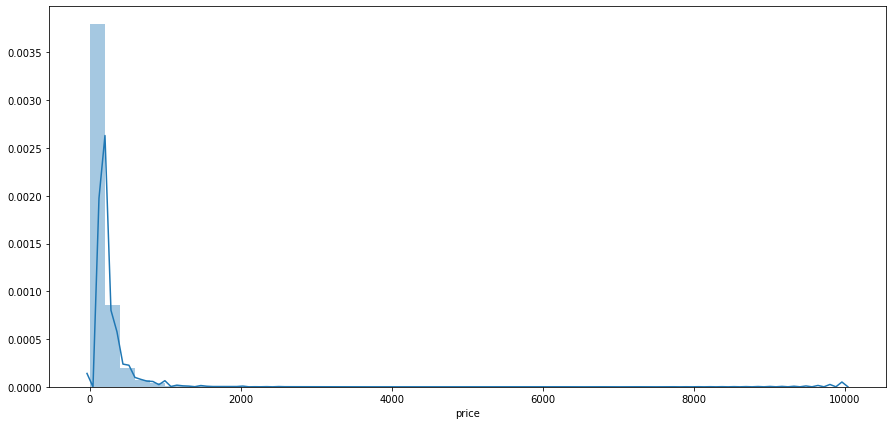

In [29]:
plt.figure(figsize=(15,7))
sns.distplot( data.price )
plt.show()

In [30]:
data[data.price == 0 ]

,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price
13245,19445144,f,1.0,t,Clontarf,-33.802398,151.254954,f,Bed and breakfast,Private room,2,1.0,1.0,1.0,Real Bed,The host canceled this reservation 15 days bef...,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1125,1,$30.00,$50.00,NaN,0.0
14243,20563580,f,2.0,f,Kogarah,-33.961377,151.138597,t,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,Li was a wonderful host and very thoughtful Sh...,f,10.0,10.0,10.0,10.0,10.0,10.0,100.0,4,0,1125,2,$40.00,$15.00,$200.00,0.0
14400,20718560,t,3.0,t,Waterloo,-33.899361,151.200712,t,Apartment,Entire home/apt,3,1.0,2.0,2.0,Real Bed,We have had a great time It was the perfect pl...,t,9.0,9.0,10.0,10.0,10.0,10.0,94.0,146,295,1125,1,$25.00,$25.00,$150.00,0.0
15051,21239881,f,1.0,f,Ultimo,-33.882266,151.196702,t,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,Nice place good location with parking A nice a...,t,10.0,9.0,10.0,10.0,9.0,10.0,90.0,3,0,1125,1,$0.00,$85.00,$150.00,0.0
15257,21372128,f,40.0,f,North Bondi,-33.887442,151.276676,t,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,Fantastic location hotel quality but with the ...,f,9.0,10.0,10.0,10.0,10.0,10.0,96.0,42,123,1125,2,$0.00,$125.00,$250.00,0.0
21126,25960573,f,0.0,f,Dulwich Hill,-33.910858,151.139156,t,Apartment,Entire home/apt,1,1.0,0.0,1.0,Real Bed,Very close to light rail and train station Som...,t,10.0,9.0,10.0,9.0,10.0,10.0,100.0,3,68,30,7,$0.00,NaN,NaN,0.0
21356,26280069,f,0.0,t,Darlinghurst,-33.880877,151.215321,f,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,The host canceled this reservation 11 days bef...,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,362,1125,1,$0.00,NaN,$150.00,0.0


In [31]:
data = data[data.price > 0]
data.shape

(24718, 32)

In [33]:
for i in range(80,100,1):
    print( i, 'th percentile : ',data.price.quantile(i/100) )

80 th percentile :  245.0
81 th percentile :  251.0
82 th percentile :  251.0
83 th percentile :  251.0
84 th percentile :  270.0
85 th percentile :  285.0
86 th percentile :  299.0
87 th percentile :  300.0
88 th percentile :  300.0
89 th percentile :  329.0
90 th percentile :  350.0
91 th percentile :  363.9400000000023
92 th percentile :  399.0
93 th percentile :  407.0
94 th percentile :  450.0
95 th percentile :  500.0
96 th percentile :  550.0
97 th percentile :  615.9799999999959
98 th percentile :  750.0
99 th percentile :  999.0


In [34]:
data[data.price > 999]['price'].describe()

count      191.000000
mean      1734.486911
std       1280.346149
min       1029.000000
25%       1200.000000
50%       1400.000000
75%       1793.000000
max      10001.000000
Name: price, dtype: float64

In [36]:
data = data[data.price <= 999]
data.shape

(24458, 32)

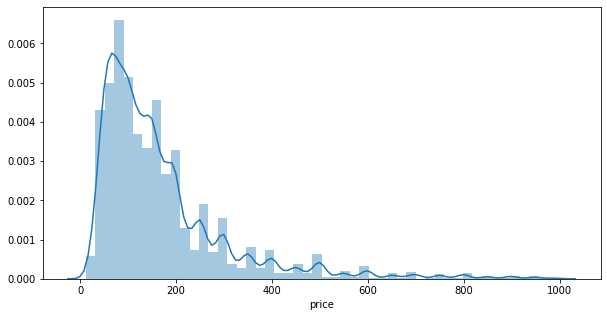

In [37]:
plt.figure(figsize=(10,5))
sns.distplot(data['price'])
plt.show()

 
<br>

In [38]:
binary = [i for i in data.columns if len(data[i].value_counts()) == 2]
binary

['host_is_superhost',
 'host_identity_verified',
 'is_location_exact',
 'instant_bookable']

In [39]:
def binarize_vars(df, vars):
    for i in vars:
        df[i] = df[i].map(lambda x: 1 if x == 't' else 0)
        df[i] = df[i].astype('int64')
    return df

data = binarize_vars(data, binary)
data.head()

,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price
0,12351,0,2.0,1,Pyrmont,-33.865153,151.191896,1,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,This was my first Airbnb experience and I am h...,0,10.0,10.0,10.0,10.0,9.0,10.0,95.0,493,187,7,2,$395.00,$55.00,$0.00,100.0
1,14250,0,2.0,1,Balgowlah,-33.800929,151.261722,1,House,Entire home/apt,6,3.0,3.0,3.0,Real Bed,We did not meet Heidi but she was very friendl...,0,10.0,10.0,8.0,10.0,10.0,10.0,100.0,1,321,22,5,$40.00,$100.00,$900.00,471.0
2,15253,0,2.0,1,Darlinghurst,-33.880455,151.216541,0,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,Morag is a helpful easy going host Her place i...,1,9.0,9.0,9.0,9.0,9.0,9.0,88.0,300,316,7,2,$10.00,NaN,NaN,109.0
3,20865,1,2.0,1,Balmain,-33.859072,151.172753,1,House,Entire home/apt,8,2.0,4.0,4.0,Real Bed,Still travelling so a little late in our revie...,0,9.0,10.0,10.0,9.0,9.0,9.0,96.0,15,69,365,7,$0.00,NaN,$800.00,450.0
4,26174,0,1.0,1,Bellevue Hill,-33.889087,151.259404,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,Great host very friendly and accomodating Apar...,0,9.0,10.0,10.0,10.0,10.0,10.0,94.0,42,140,60,1,$15.00,$25.00,$0.00,62.0



<br>

<b>===Separating datatypes===

In [40]:
conv = ['host_total_listings_count', 'bathrooms', 'bedrooms', 'beds', 'review_scores_value', 'review_scores_location',\
        'review_scores_communication', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_accuracy',\
        'review_scores_rating']

In [41]:
cont = [i for i in data.columns if data[i].dtype == 'float64']
cont.remove('price')


cat = [i for i in data.columns if data[i].dtype == 'O']
cat.remove('reviews_clubbed')

for i in ['extra_people', 'cleaning_fee', 'security_deposit']:
    cat.remove(i)
    cont.append(i)


disc = [i for i in data.columns if data[i].dtype == 'int64']
disc.remove('id')

cat,cont, disc

(['city', 'property_type', 'room_type', 'bed_type'],
 ['host_total_listings_count',
  'latitude',
  'longitude',
  'bathrooms',
  'bedrooms',
  'beds',
  'review_scores_value',
  'review_scores_location',
  'review_scores_communication',
  'review_scores_checkin',
  'review_scores_cleanliness',
  'review_scores_accuracy',
  'review_scores_rating',
  'extra_people',
  'cleaning_fee',
  'security_deposit'],
 ['host_is_superhost',
  'host_identity_verified',
  'is_location_exact',
  'accommodates',
  'instant_bookable',
  'number_of_reviews',
  'availability_365',
  'maximum_nights',
  'minimum_nights'])

In [42]:
for i in conv:
    cont.remove(i)
    disc.append(i)
    
del conv


<br>

### Splitting the data into train test

In [43]:
train, test = train_test_split( data, test_size=0.3)
train.shape, test.shape

((17120, 32), (7338, 32))

<b>===New features (missing value indicators)===

In [44]:
b = train.isna().sum()
missing = b[b > 0].index.tolist()
del b

In [45]:
for var in missing:
    train[var+'_missing'] = [int(i) for i in  train[var].isna()]
    test[var+'_missing'] = [int(i) for i in  test[var].isna()]
    disc.append(var+'_missing')
train.shape, test.shape

((17120, 46), (7338, 46))

<b>===Issues after splitting===

In [46]:
for var in cat:
    print('Variable : ', var)
    print('Not in train but in test : ', [i for i in test[var].unique() if i not in train[var].unique() ])
#     print('Not in test but in train :', [i for i in train[var].unique() if i not in test[var].unique() ])
    print('\n')
    print('='*90)
    print('\n')

Variable :  city
Not in train but in test :  ['Duffys Forest', 'Luddenham', 'Little bay', 'Dolans Bay', 'Saint Helens Park', 'Saint Clair', 'Bronte ', 'Oxford Falls', 'Mount Pritchard', 'Denham Court', 'Bellevue Hill (Double Bay side).', 'Bondi beach', 'North Curl Curl (near Manly)', 'Oran Park', 'Kellyville NSW 2155', 'Canoelands', 'Old Toongabbie', 'Cattai', 'Maroubra, New South Wales, AU', ' Bondi Beach', 'Abbotsbury', '悉尼市', 'Canley Vale', 'Lane Cove Municipal Council', 'Woodbine', 'Kareela', 'zetland', 'Manly/Queenscliff', 'Sydney, Bondi Beach', 'Northern Beaches', 'Haberfield ', 'Coogee ', 'Coogee, New South Wales, Australia', 'Darling Harbour', 'Queens Park ', 'Penrith, New South Wales, AU', 'Leumeah', 'Bonnet Bay', 'Auburn / Lidcomb ', 'Balmoral Beach', 'Seven Hills    ', 'waterloo', 'Wentworth Point ', 'Erskine Park', 'Yarrawarrah', 'Rushcutters Bay ', 'Padstow Heights', 'Darlinghurst Sydney', 'Kensington, Sydney', 'North Sydney NSW 2060', 'Kensington ', 'Wollstonecraft, Sydne

<b>===Handling this issue===

In [47]:
def rare_categories(train_var, actual_var, tolerance):
    actual_var = actual_var.fillna( mode(train_var) )
    
    rare = []
    categories = train_var.unique().tolist()
    for i,j in (train_var.value_counts()/len(train_var)).to_dict().items():
        if j < tolerance:
            rare.append(i)
    var = []
    for i in actual_var:
        if (i in rare)|(i not in categories):
            var.append('Others')
        else:
            var.append(i)
    return var

In [48]:
for i in cat:
    print(i)
    print( 'Categories : ',len(train[i].unique()) )
    print( 'Avg. data points per category in a variable', len(data)/len(data[i].unique()) )
    print('='*90)

city
Categories :  633
Avg. data points per category in a variable 34.49647390691114
property_type
Categories :  35
Avg. data points per category in a variable 661.027027027027
room_type
Categories :  3
Avg. data points per category in a variable 8152.666666666667
bed_type
Categories :  5
Avg. data points per category in a variable 4891.6


In [49]:
for i in cat:
    train[i] = rare_categories(train[i], train[i], 0.02)
    test[i] = rare_categories(train[i], test[i], 0.02)

In [50]:
for i in cat:
    print('Variable : ',i)
    print(train[i].value_counts()/len(train))
    print('\n')
    print(test[i].value_counts()/len(test))
    print('='*90)

Variable :  city
Others          0.750292
Bondi Beach     0.053271
Surry Hills     0.040012
Manly           0.033703
Sydney          0.029614
Darlinghurst    0.025935
Bondi           0.023540
Coogee          0.022664
Randwick        0.020970
Name: city, dtype: float64


Others          0.746797
Bondi Beach     0.054920
Surry Hills     0.040065
Sydney          0.030390
Darlinghurst    0.028754
Manly           0.028482
Bondi           0.026301
Coogee          0.022758
Randwick        0.021532
Name: city, dtype: float64
Variable :  property_type
Apartment      0.594159
House          0.247547
Others         0.083236
Townhouse      0.049766
Condominium    0.025292
Name: property_type, dtype: float64


Apartment      0.602344
House          0.246525
Others         0.083538
Townhouse      0.043609
Condominium    0.023985
Name: property_type, dtype: float64
Variable :  room_type
Entire home/apt    0.641881
Private room       0.344918
Others             0.013201
Name: room_type, dtype: float64

 
 <br>

<b>===Converting the supposedly numerical vars but currently object===

In [51]:
convert_to_num = train[ train.dtypes[ train.dtypes == 'O' ].index ].columns[-3:].tolist()

In [52]:
convert_to_num

['extra_people', 'cleaning_fee', 'security_deposit']

In [53]:
for i in convert_to_num:
    train[i] = train[i].fillna('0')
    test[i] = test[i].fillna('0')
    print(i,' has missing values in train : ', train[i].isna().any() )
    print(i,' has missing values in test : ', test[i].isna().any() )

for i in convert_to_num:
    train[i] = train[i].str.replace(",","").str.replace("$","").astype('float64') 
    test[i]= test[i].str.replace(",","").str.replace("$","").astype('float64') 

train[convert_to_num].head()

extra_people  has missing values in train :  False
extra_people  has missing values in test :  False
cleaning_fee  has missing values in train :  False
cleaning_fee  has missing values in test :  False
security_deposit  has missing values in train :  False
security_deposit  has missing values in test :  False


,extra_people,cleaning_fee,security_deposit
6016,0.0,70.0,295.0
16270,0.0,75.0,0.0
24705,0.0,80.0,150.0
7054,50.0,100.0,0.0
4779,50.0,70.0,500.0



<br>
<br>

### Exploring variables:

In [35]:
# import geopandas as gpd
# Longitude lattitude vs price plot

<b>===Continuous variables===

In [54]:
def list_of_pairplots(df, var_list):
    from itertools import combinations
    combs = []
    for i,j in combinations(var_list, 2):
        combs.append((i,j))
    
    for pair in combs:
        plt.scatter( df[pair[0]], df[pair[1]] )
        plt.xlabel(pair[0])
        plt.ylabel(pair[1])
        plt.show()

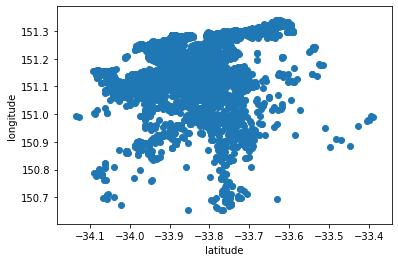

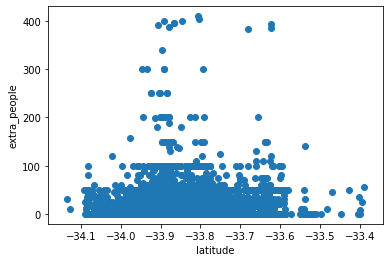

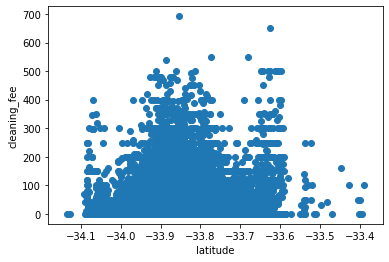

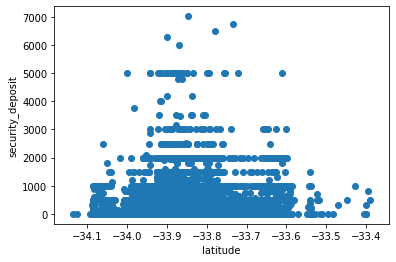

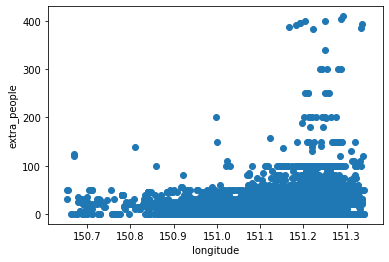

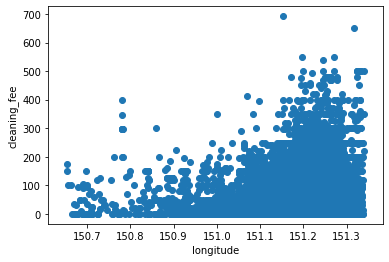

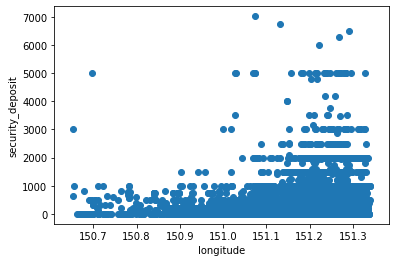

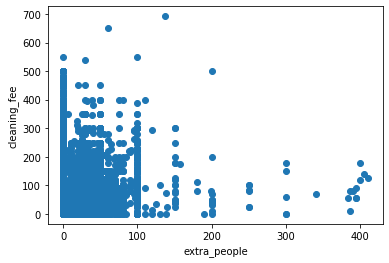

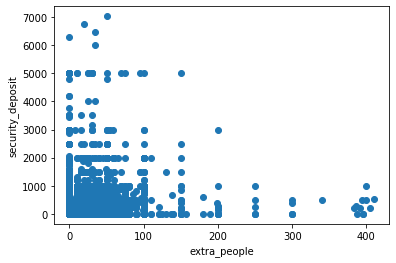

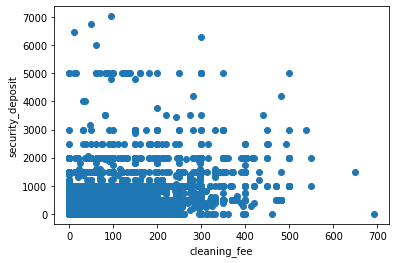

In [55]:
list_of_pairplots(train, cont)

There are some variables with weak realtionships between them, and some seem completely randomly distributed against each other.

Variable :  latitude


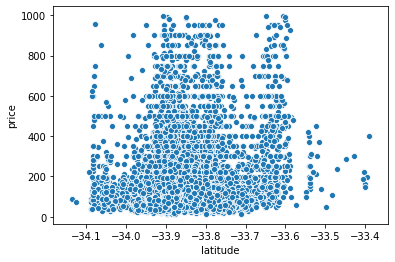

Variable :  longitude


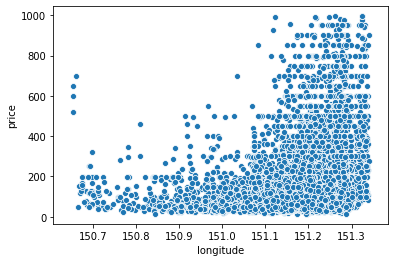

Variable :  extra_people


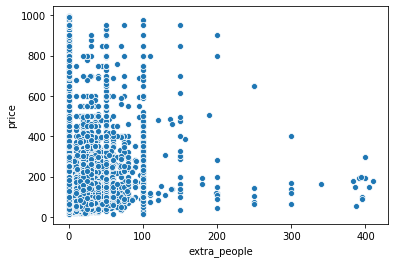

Variable :  cleaning_fee


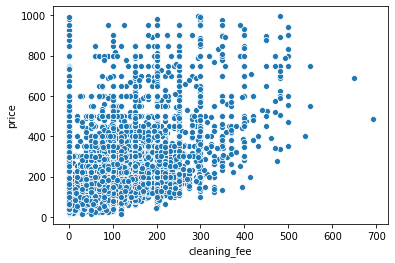

Variable :  security_deposit


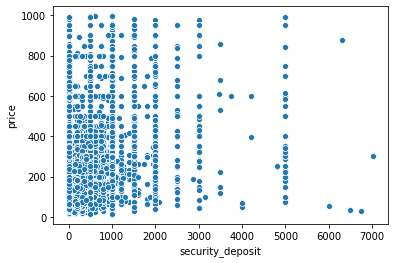

In [56]:
for vars in cont:
    if vars != 'price':
        print('Variable : ',vars)
        sns.scatterplot( x=vars, y='price', data=train)
        plt.show()

Variables like longitude, extra people and cleaning fee show some weak pattern.

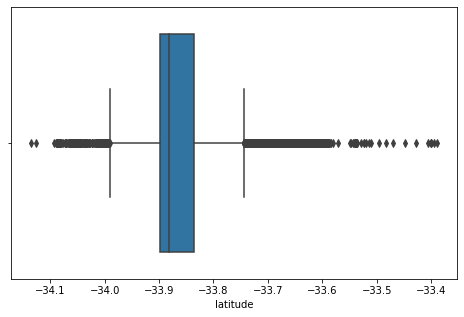

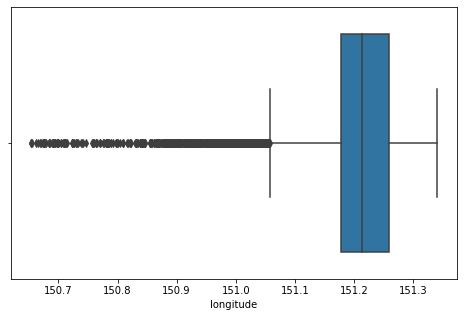

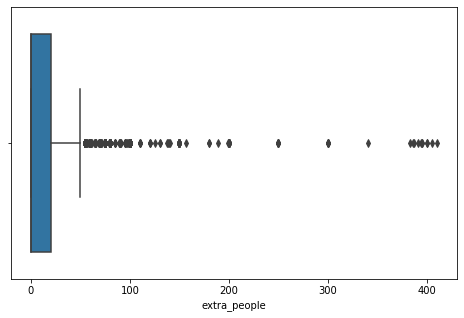

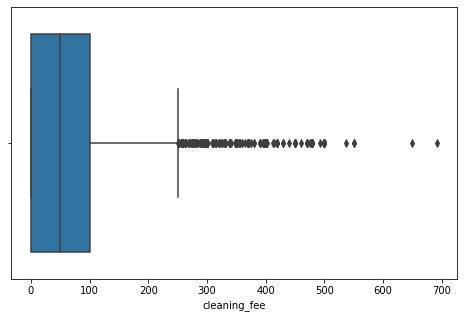

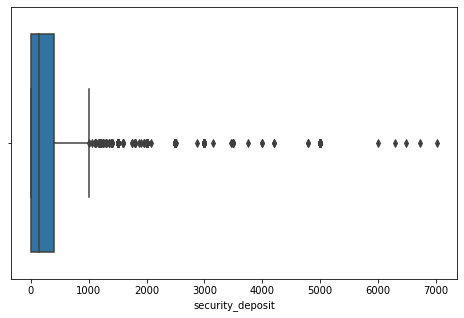

In [57]:
for vars in cont:
    if vars != 'price':
        plt.figure(figsize=(8,5))
        sns.boxplot( x=vars, data=train)
        plt.show()


<br>

<b>===Discrete variables===

<i>::Groupby means plot::

In [58]:
for i in disc:
    print(i)
    print( len(train[i].unique()))
    print('='*90)

host_is_superhost
2
host_identity_verified
2
is_location_exact
2
accommodates
16
instant_bookable
2
number_of_reviews
265
availability_365
366
maximum_nights
178
minimum_nights
67
host_total_listings_count
63
bathrooms
16
bedrooms
11
beds
19
review_scores_value
10
review_scores_location
9
review_scores_communication
10
review_scores_checkin
10
review_scores_cleanliness
10
review_scores_accuracy
10
review_scores_rating
48
host_total_listings_count_missing
2
city_missing
2
bathrooms_missing
2
bedrooms_missing
2
beds_missing
2
review_scores_value_missing
2
review_scores_location_missing
2
review_scores_communication_missing
2
review_scores_checkin_missing
2
review_scores_cleanliness_missing
2
review_scores_accuracy_missing
2
review_scores_rating_missing
2
cleaning_fee_missing
2
security_deposit_missing
2


In [59]:
train.review_scores_rating.unique()

array([ 96., 100.,  97.,  60.,  99.,  95.,  84.,  88.,  92.,  80.,  90.,
        85.,  98.,  93.,  91.,  87.,  83.,  86.,  nan,  94.,  89.,  70.,
        82.,  75.,  40.,  67.,  20.,  77.,  71.,  72.,  76.,  78.,  73.,
        81.,  79.,  74.,  53.,  47.,  69.,  68.,  65.,  30.,  55.,  50.,
        56.,  63.,  66.,  64.])

accommodates


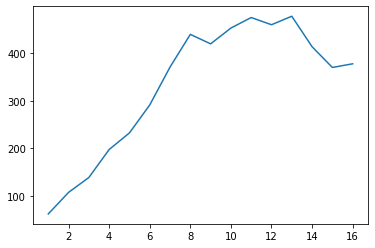

number_of_reviews


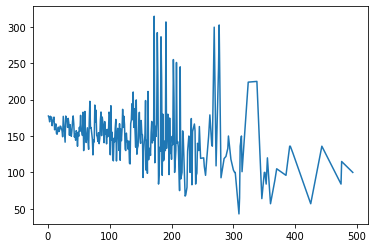

availability_365


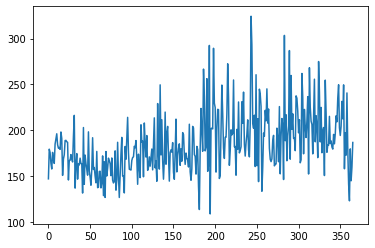

maximum_nights


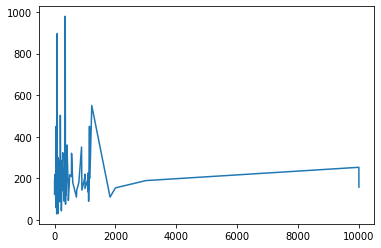

minimum_nights


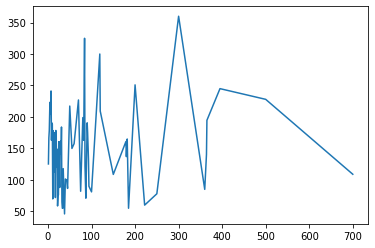

host_total_listings_count


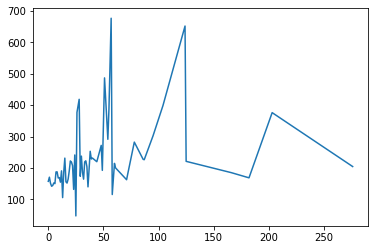

bathrooms


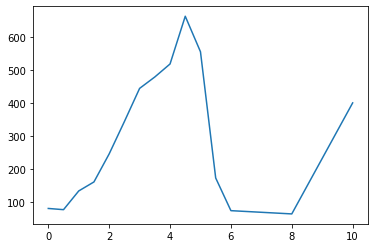

bedrooms


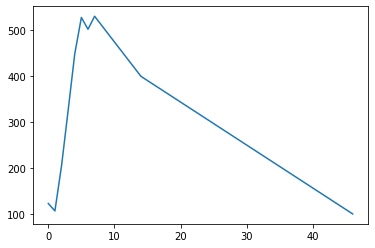

beds


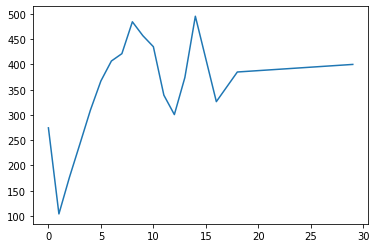

review_scores_value


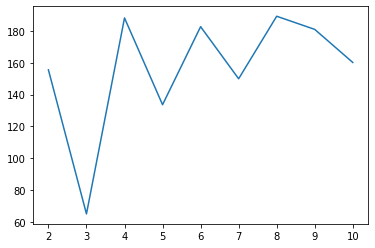

review_scores_location


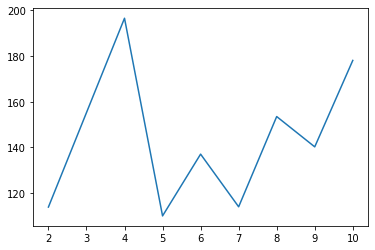

review_scores_communication


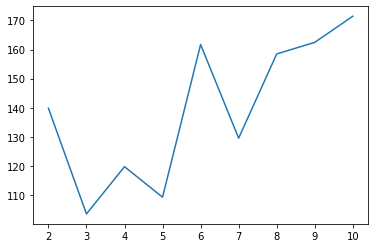

review_scores_checkin


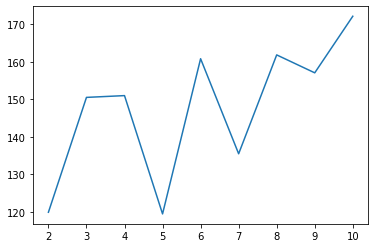

review_scores_cleanliness


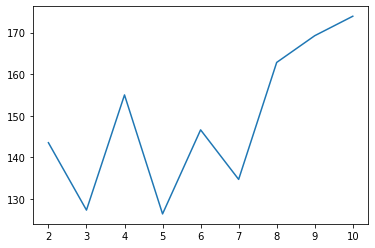

review_scores_accuracy


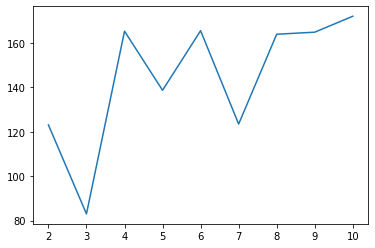

review_scores_rating


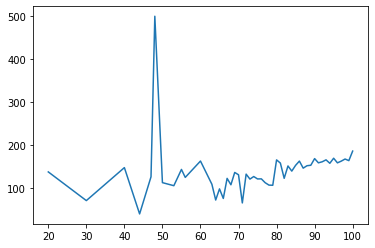

In [60]:
for i in disc:
    if len(train[i].unique()) > 6:
        print(i)
        plt.plot( data.groupby(i)['price'].mean() )
        plt.show()

Most variables pretty much vary w.r.t the target variable

Variable : host_is_superhost


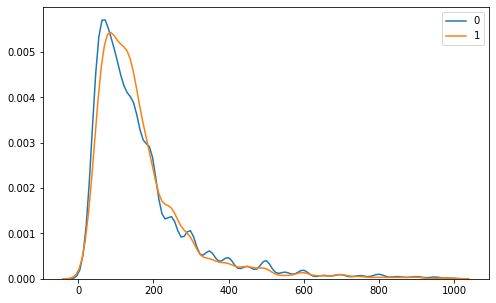

Variable : host_identity_verified


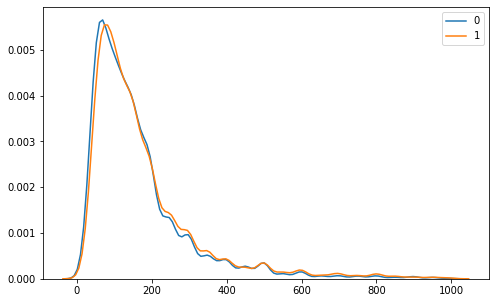

Variable : is_location_exact


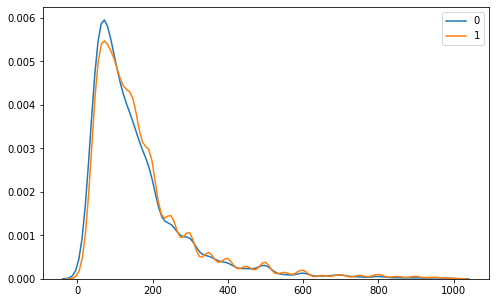

Variable : instant_bookable


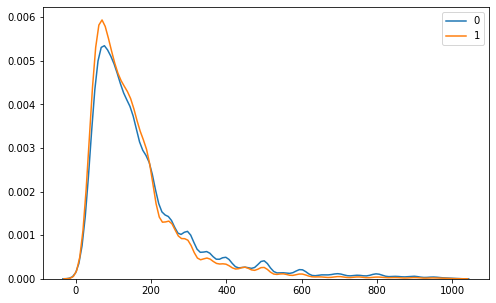

Variable : host_total_listings_count_missing


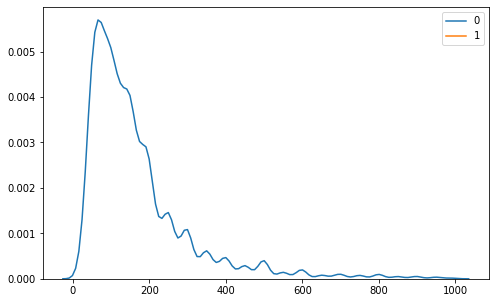

Variable : city_missing


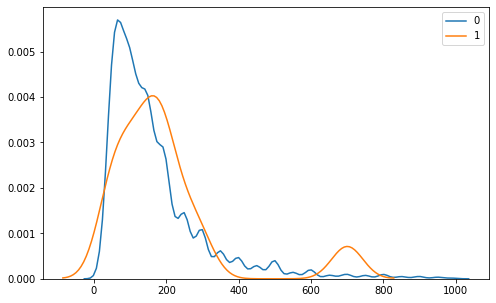

Variable : bathrooms_missing


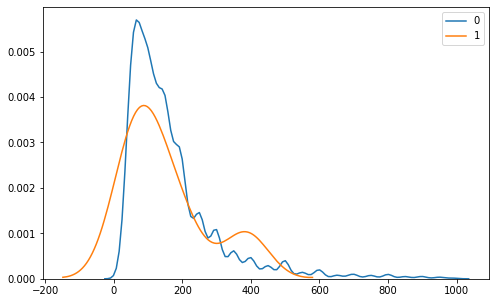

Variable : bedrooms_missing


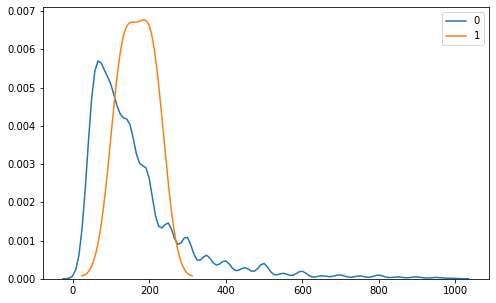

Variable : beds_missing


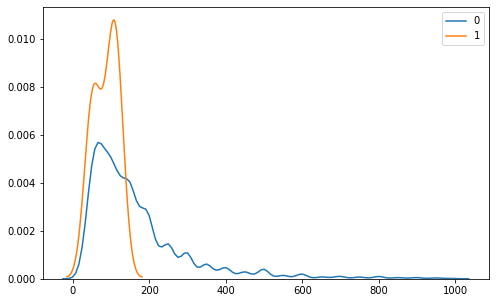

Variable : review_scores_value_missing


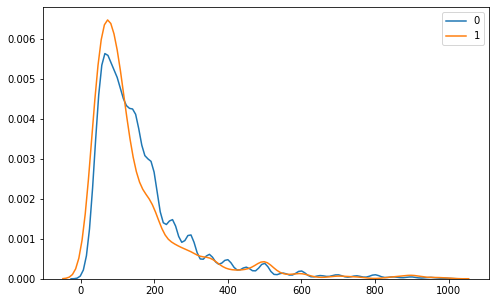

Variable : review_scores_location_missing


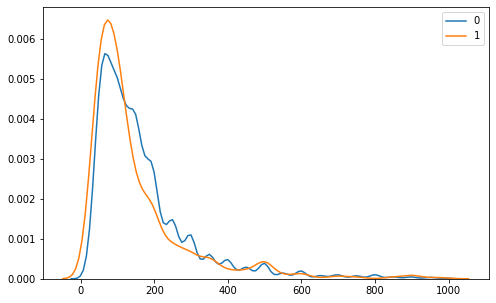

Variable : review_scores_communication_missing


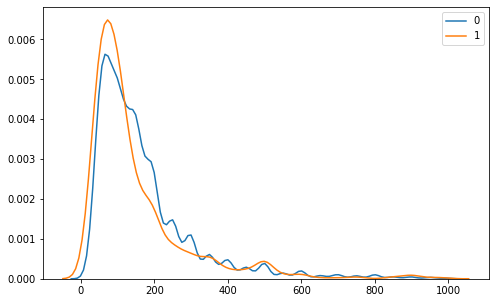

Variable : review_scores_checkin_missing


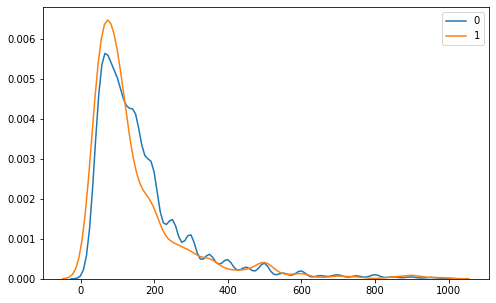

Variable : review_scores_cleanliness_missing


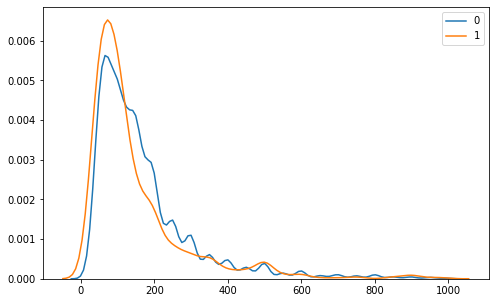

Variable : review_scores_accuracy_missing


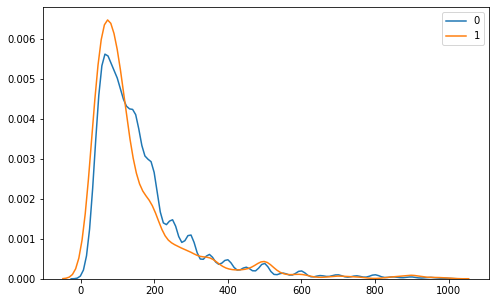

Variable : review_scores_rating_missing


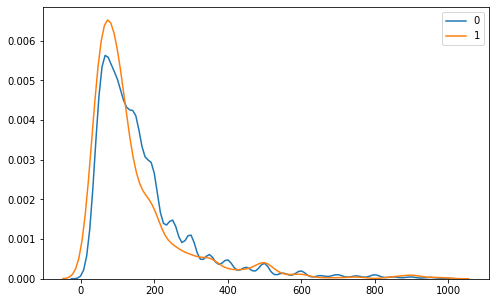

Variable : cleaning_fee_missing


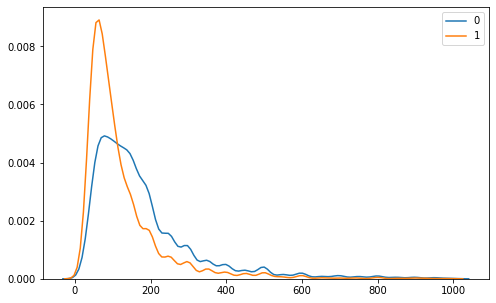

Variable : security_deposit_missing


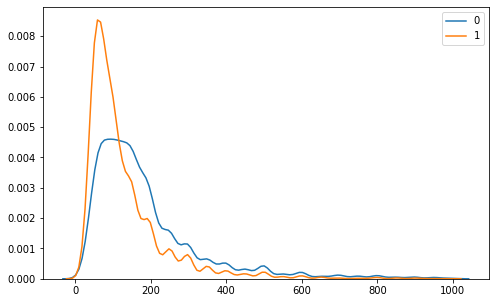

In [61]:
for i in disc:
    if len( train[i].unique() ) < 6:
        temp = train.groupby(i)
        print('Variable :',i)
        plt.figure(figsize=(8,5))
        for idx, frame in temp:
            sns.kdeplot( frame['price'], label = idx )
        plt.legend()
        plt.show()

The distibutions w.r.t these variables seem pretty similar, these probably do not add much value to the model.

Variables who have missing values like host_total_listings, city, bedrooms, cleaning_fee, security_deposit, their missingness also shows some pattern for predicting the target.

 
 <br>

<b>===Categorical variables===

<i>::Groupby plots for means::

city


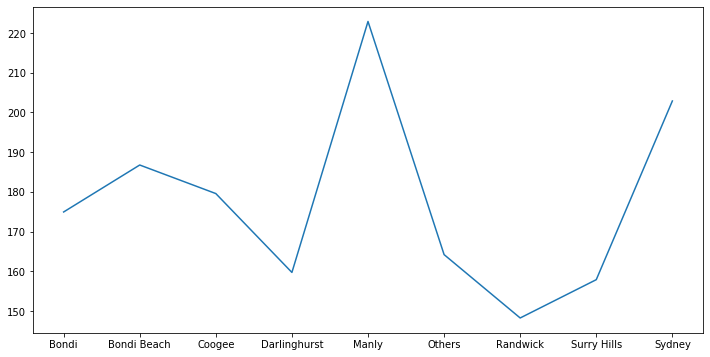

property_type


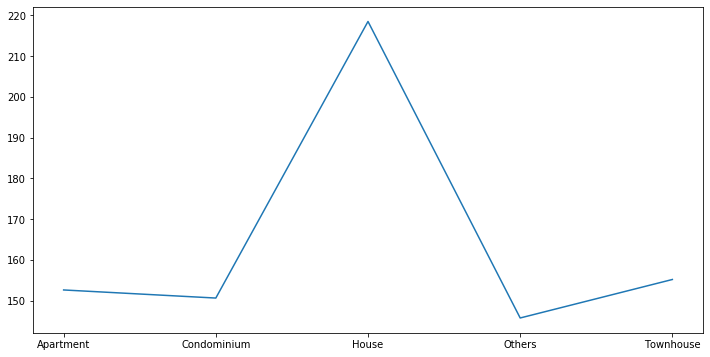

room_type


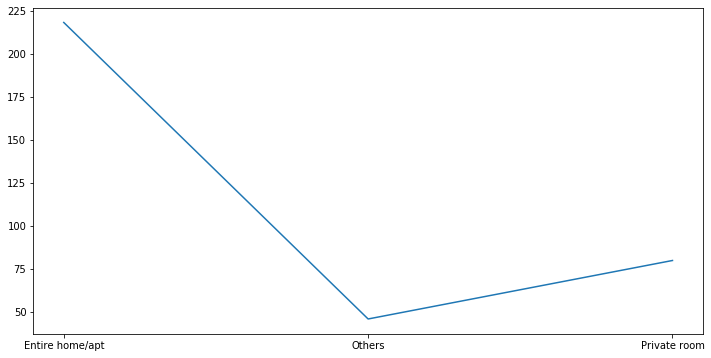

bed_type


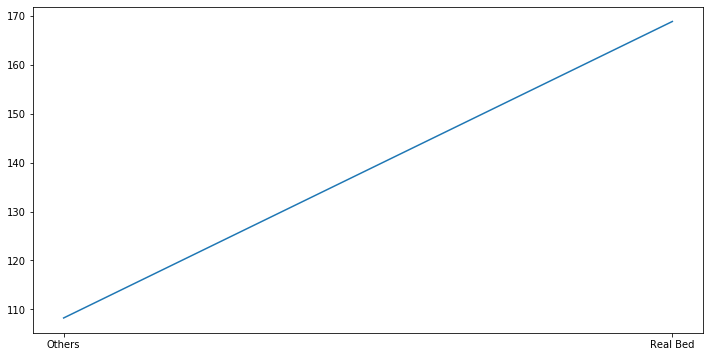

In [62]:
for i in cat:
    print(i)
    plt.figure(figsize=(12,6))
    plt.plot( train.groupby(i)['price'].mean() )
    plt.show()

Variable : property_type


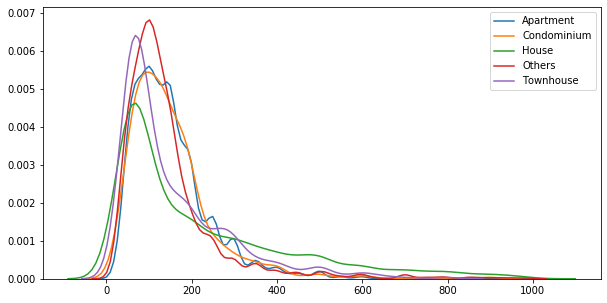

Variable : room_type


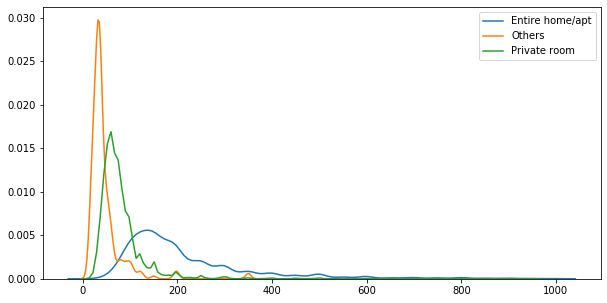

Variable : bed_type


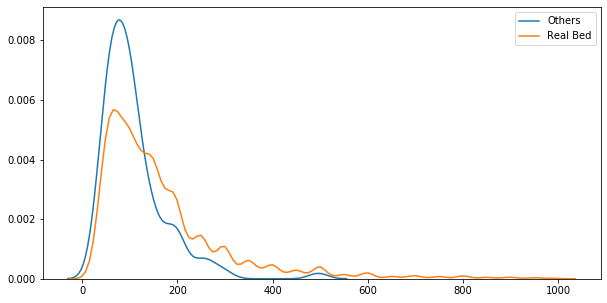

In [63]:
for i in cat:
    if len(train[i].unique()) < 6:
        temp = train.groupby(i)
        print('Variable :',i)
        plt.figure(figsize=(10,5))
        for idx, frame in temp:
            sns.kdeplot( frame['price'], label = idx )
        plt.legend()
        plt.show()

Categorical variables seem fairly meaningful as they have well separated distributions.


<br>

### Correlation analysis:

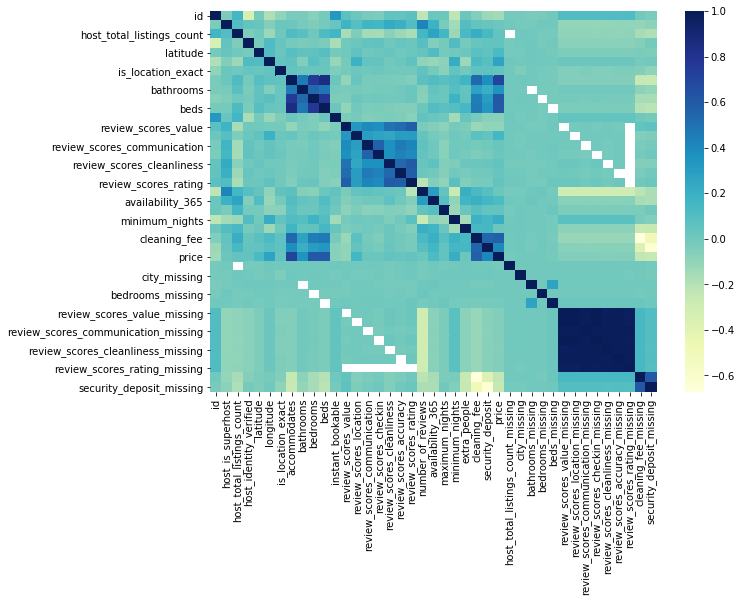

In [64]:
plt.figure(figsize=(10,7))
sns.heatmap(train.corr(method='spearman') , cmap='YlGnBu')
plt.show()

Variables like security deposit, cleaning fee, beds, bedroms, bathrooms, accomodates have the highest correlations amongst each other.

In [65]:
train.corr(method='spearman')['price']

id                                    -0.141676
host_is_superhost                      0.018504
host_total_listings_count              0.046708
host_identity_verified                 0.049228
latitude                               0.127100
longitude                              0.272964
is_location_exact                      0.049860
accommodates                           0.707318
bathrooms                              0.356519
bedrooms                               0.608651
beds                                   0.601594
instant_bookable                      -0.067128
review_scores_value                   -0.091261
review_scores_location                 0.154286
review_scores_communication            0.029893
review_scores_checkin                  0.022627
review_scores_cleanliness              0.053452
review_scores_accuracy                 0.036992
review_scores_rating                   0.045781
number_of_reviews                      0.024577
availability_365                       0


<br>

### Handling missing values:

In [66]:
## Categoric vars

train[cat].isna().sum().any(), test[cat].isna().sum().any()

(False, False)

In [67]:
## Continuous vars

train[cont].isna().sum().any(), test[cont].isna().sum().any()

(False, False)

In [68]:
## Discrete vars

train[disc].isna().sum().any(), test[disc].isna().sum().any()

(True, True)

In [69]:
si = SimpleImputer(strategy='most_frequent').fit(train[disc])

train[disc] = si.transform(train[disc])
test[disc] = si.transform(test[disc])

In [70]:
train[disc].isna().sum().any(), test[disc].isna().sum().any()

(False, False)


<br>

### Handling outliers:

In [71]:
train.describe()

,id,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price,host_total_listings_count_missing,city_missing,bathrooms_missing,bedrooms_missing,beds_missing,review_scores_value_missing,review_scores_location_missing,review_scores_communication_missing,review_scores_checkin_missing,review_scores_cleanliness_missing,review_scores_accuracy_missing,review_scores_rating_missing,cleaning_fee_missing,security_deposit_missing
count,1.712000e+04,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000,17120.00000,17120.000000,17120.000000,17120.000000,17120.000000,17120.000000
mean,1.710541e+07,0.171437,8.348890,0.418166,-33.864317,151.201310,0.743750,3.350000,1.301548,1.525993,1.961741,0.419451,9.385222,9.682243,9.749182,9.745035,9.288668,9.583236,93.725584,18.205841,103.800058,683.971086,4.414778,12.939252,66.034755,262.952220,168.432360,0.000058,0.000759,0.000350,0.000234,0.000526,0.048715,0.048657,0.047371,0.04854,0.047138,0.047897,0.046203,0.212558,0.311449
std,8.124395e+06,0.376901,30.523821,0.493272,0.070933,0.083511,0.436574,2.070276,0.580814,1.033309,1.442674,0.493484,0.989886,0.721577,0.771710,0.752824,1.195807,0.912601,9.554376,33.697647,123.118383,552.276115,15.921018,23.586601,73.585779,458.285485,138.765867,0.007643,0.027547,0.018718,0.015284,0.022923,0.215278,0.215155,0.212438,0.21491,0.211940,0.213555,0.209931,0.409130,0.463099
min,1.235100e+04,0.000000,0.000000,0.000000,-34.135212,150.653748,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,20.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.010403e+07,0.000000,1.000000,0.000000,-33.898107,151.177782,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,9.000000,10.000000,10.000000,10.000000,9.000000,9.000000,91.000000,2.000000,0.000000,30.000000,1.000000,0.000000,0.000000,0.000000,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.840734e+07,0.000000,1.000000,0.000000,-33.882217,151.213463,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,97.000000,5.000000,49.000000,1125.000000,2.000000,0.000000,50.000000,140.000000,130.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.315090e+07,0.000000,3.000000,1.000000,-33.836560,151.258329,1.000000,4.000000,1.500000,2.000000,2.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,19.000000,175.000000,1125.000000,4.000000,20.000000,100.000000,400.000000,199.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.054962e+07,1.000000,276.000000,1.000000,-33.389728,151.339678,1.000000,16.000000,10.000000,46.000000,29.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,493.000000,365.000000,10000.000000,700.000000,410.000000,692.000000,7021.000000,995.000000,1.000000,1.000000,1.000000,1

 
 <br>

In [72]:
train[ train.maximum_nights > 365*5 ]

,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price,host_total_listings_count_missing,city_missing,bathrooms_missing,bedrooms_missing,beds_missing,review_scores_value_missing,review_scores_location_missing,review_scores_communication_missing,review_scores_checkin_missing,review_scores_cleanliness_missing,review_scores_accuracy_missing,review_scores_rating_missing,cleaning_fee_missing,security_deposit_missing
136,389876,1.0,3.0,0.0,Others,-33.889261,151.201722,1.0,Apartment,Entire home/apt,4.0,1.0,1.0,0.0,Real Bed,Beautiful place owned by an amazing host Paul ...,1.0,10.0,10.0,10.0,10.0,10.0,10.0,98.0,443.0,208.0,10000.0,1.0,50.0,87.0,300.0,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6564,10733532,1.0,3.0,1.0,Others,-33.902506,151.186476,0.0,Apartment,Entire home/apt,4.0,1.0,2.0,2.0,Real Bed,Millie was an excellent host easy to communica...,0.0,10.0,10.0,10.0,10.0,9.0,10.0,98.0,20.0,284.0,2000.0,14.0,0.0,150.0,250.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1795,3835553,0.0,3.0,0.0,Others,-33.741035,151.025814,1.0,Others,Private room,2.0,1.5,1.0,1.0,Real Bed,Easy process Excellent communication Lovely ho...,0.0,10.0,10.0,10.0,10.0,9.0,9.0,95.0,25.0,60.0,2000.0,2.0,15.0,25.0,150.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5094,9201518,0.0,1.0,0.0,Sydney,-33.869591,151.205333,1.0,Apartment,Entire home/apt,3.0,1.0,0.0,2.0,Real Bed,The apartment was fantastical located the cafe...,0.0,10.0,10.0,10.0,10.0,9.0,9.0,92.0,31.0,279.0,9999.0,3.0,20.0,100.0,200.0,260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16330,21897829,1.0,1.0,0.0,Manly,-33.797491,151.287411,0.0,Apartment,Entire home/apt,4.0,1.0,1.0,2.0,Real Bed,The apartment is in the heart of Manly and was...,1.0,9.0,10.0,10.0,10.0,10.0,10.0,95.0,22.0,160.0,10000.0,2.0,0.0,100.0,0.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10099,16059459,0.0,1.0,1.0,Others,-33.889988,151.193362,1.0,Apartment,Entire home/apt,2.0,1.0,0.0,1.0,Real Bed,Lachlan was a fantastic host for my very quick...,0.0,9.0,10.0,10.0,10.0,9.0,10.0,93.0,20.0,6.0,3000.0,12.0,0.0,50.0,150.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402,871059,0.0,2.0,1.0,Others,-33.821991,151.243818,1.0,Apartment,Entire home/apt,7.0,1.0,2.0,3.0,Real Bed,We have just returned to Sydney after living i...,1.0,9.0,10.0,10.0,10.0,9.0,10.0,94.0,138.0,336.0,3000.0,1.0,25.0,99.0,300.0,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11595,17256885,1.0,1.0,0.0,Sydney,-33.872063,151.206279,1.0,Condominium,Entire home/apt,6.0,1.5,2.0,4.0,Real Bed,Super great location And it s a large and clea...,1.0,10.0,10.0,10.0,10.0,10.0,10.0,97.0,110.0,58.0,2000.0,2.0,30.0,80.0,250.0,282.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11818,17562170,0.0,2.0,1.0,Others,-33.999158,151.048046,0.0,House,Private room,2.0,1.0,1.0,1.0,Real Bed,Lois was realt kind and her family was support...,0.0,10.0,10.0,10.0,10.0,9.0,9.0,90.0,2.0,170.0,3000.0,1.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
11384,16967050,1.0,1.0,0.0,Others,-33.859618,151.091033,1.0,House,Entire home/apt,7.0,3.0,3.0,4.0,Real Bed,Lovely new house Great facilities and host Hel...,0.0,10.0,10.0,10.0,10.0,10.0,10.0,97.0,47.0,276.0,9999.0,2.0,20.0,80.0,300.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
test[ test.maximum_nights > 365*5 ]

,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price,host_total_listings_count_missing,city_missing,bathrooms_missing,bedrooms_missing,beds_missing,review_scores_value_missing,review_scores_location_missing,review_scores_communication_missing,review_scores_checkin_missing,review_scores_cleanliness_missing,review_scores_accuracy_missing,review_scores_rating_missing,cleaning_fee_missing,security_deposit_missing
3762,6925526,1.0,1.0,1.0,Coogee,-33.917894,151.254181,0.0,Apartment,Entire home/apt,6.0,1.0,2.0,3.0,Real Bed,Very nice renovated apartment with everything ...,0.0,9.0,10.0,10.0,10.0,10.0,10.0,98.0,57.0,266.0,3000.0,1.0,20.0,150.0,130.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Seems some kind of error for maximum nights max values

In [74]:
train[ train.accommodates == train.accommodates.max() ]

,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price,host_total_listings_count_missing,city_missing,bathrooms_missing,bedrooms_missing,beds_missing,review_scores_value_missing,review_scores_location_missing,review_scores_communication_missing,review_scores_checkin_missing,review_scores_cleanliness_missing,review_scores_accuracy_missing,review_scores_rating_missing,cleaning_fee_missing,security_deposit_missing
7561,12743328,0.0,10.0,1.0,Others,-33.887910,151.133702,1.0,House,Private room,16.0,8.0,6.0,8.0,Real Bed,I had a really comfortable stay at Ashfield Ma...,0.0,10.0,9.0,10.0,10.0,10.0,10.0,93.0,20.0,338.0,120.0,1.0,40.0,25.0,500.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1261,2494694,0.0,203.0,1.0,Others,-33.927193,151.249404,1.0,House,Entire home/apt,16.0,3.0,6.0,10.0,Real Bed,This home was the perfect place for our family...,0.0,9.0,9.0,8.0,7.0,9.0,9.0,85.0,4.0,6.0,1125.0,4.0,0.0,480.0,500.0,624.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12756,18827491,0.0,2.0,1.0,Others,-33.892470,151.255225,1.0,Apartment,Entire home/apt,16.0,1.0,1.0,1.0,Real Bed,The host canceled this reservation 222 days be...,1.0,10.0,10.0,10.0,10.0,10.0,10.0,100.0,2.0,340.0,1125.0,5.0,300.0,150.0,400.0,168.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15753,21648296,0.0,2.0,1.0,Others,-33.898422,151.096432,1.0,House,Entire home/apt,16.0,3.0,7.0,18.0,Real Bed,great place to stay in lovely houseViola was a...,0.0,9.0,9.0,10.0,10.0,10.0,10.0,98.0,10.0,326.0,1124.0,2.0,32.0,396.0,0.0,385.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15946,21742540,0.0,4.0,0.0,Others,-33.954821,150.866718,0.0,House,Entire home/apt,16.0,2.5,6.0,13.0,Real Bed,Judy definitely deserve the super host status ...,1.0,9.0,9.0,10.0,10.0,9.0,9.0,95.0,25.0,153.0,1125.0,1.0,35.0,200.0,800.0,269.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,3079446,0.0,60.0,1.0,Others,-33.389728,150.989340,1.0,Others,Entire home/apt,16.0,10.0,14.0,29.0,Real Bed,A great place for a large group in a tranquil ...,0.0,9.0,10.0,9.0,10.0,9.0,9.0,94.0,14.0,319.0,59.0,2.0,55.0,100.0,500.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8929,14906472,1.0,1.0,0.0,Others,-33.906709,151.152222,1.0,House,Entire home/apt,16.0,2.5,6.0,16.0,Real Bed,The house was so good room was clean and beds ...,0.0,10.0,10.0,10.0,10.0,10.0,10.0,97.0,64.0,321.0,1125.0,3.0,40.0,100.0,500.0,450.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13727,19990097,0.0,1.0,0.0,Others,-33.987568,150.879702,0.0,House,Entire home/apt,16.0,2.0,3.0,14.0,Real Bed,AwesomeThis is a big house and the host is ver...,1.0,9.0,10.0,10.0,10.0,9.0,10.0,94.0,47.0,306.0,1125.0,1.0,15.0,155.0,200.0,186.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10969,16522179,0.0,17.0,1.0,Others,-34.072485,150.781766,0.0,House,Entire home/apt,16.0,2.5,5.0,10.0,Real Bed,Great house and room family was very niceGood ...,1.0,9.0,9.0,10.0,10.0,10.0,9.0,90.0,12.0,358.0,1125.0,1.0,39.0,348.0,990.0,296.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7567,12751394,0.0,3.0,0.0,Others,-33.946232,151.258208,0.0,House,Entire home/apt,16.0,3.0,4.0,10.0,Real Bed,Great views Very spacious 8 10 house was very ...,1.0,9.0,10.0,10.0,10.0,8.0,9.0,90.0,77.0,342.0,1125.0,1.0,50.0,400.0,1000.0,599.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
test[ test.accommodates == train.accommodates.max() ]

,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price,host_total_listings_count_missing,city_missing,bathrooms_missing,bedrooms_missing,beds_missing,review_scores_value_missing,review_scores_location_missing,review_scores_communication_missing,review_scores_checkin_missing,review_scores_cleanliness_missing,review_scores_accuracy_missing,review_scores_rating_missing,cleaning_fee_missing,security_deposit_missing
12107,17910938,0.0,17.0,1.0,Others,-34.071455,150.781789,0.0,House,Entire home/apt,16.0,2.5,5.0,10.0,Real Bed,Lovely home and the hosts were very friendly a...,1.0,9.0,9.0,9.0,9.0,9.0,9.0,93.0,3.0,358.0,1125.0,1.0,39.0,348.0,990.0,296.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11704,17387039,0.0,8.0,1.0,Surry Hills,-33.884160,151.210669,0.0,Townhouse,Entire home/apt,16.0,2.0,6.0,12.0,Real Bed,Brady was fantastic to deal with and the accom...,0.0,9.0,10.0,10.0,10.0,9.0,9.0,92.0,31.0,304.0,1125.0,1.0,50.0,180.0,0.0,695.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11031,16572465,0.0,17.0,1.0,Others,-34.070535,150.780012,0.0,House,Entire home/apt,16.0,2.5,5.0,9.0,Real Bed,Loved the place very clean and comfortable It ...,1.0,9.0,9.0,10.0,10.0,10.0,8.0,84.0,5.0,352.0,1125.0,1.0,39.0,348.0,990.0,296.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
train[train.bedrooms > 16]

,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price,host_total_listings_count_missing,city_missing,bathrooms_missing,bedrooms_missing,beds_missing,review_scores_value_missing,review_scores_location_missing,review_scores_communication_missing,review_scores_checkin_missing,review_scores_cleanliness_missing,review_scores_accuracy_missing,review_scores_rating_missing,cleaning_fee_missing,security_deposit_missing
17451,22311745,0.0,2.0,0.0,Others,-33.779739,151.113899,0.0,Others,Private room,1.0,1.0,46.0,1.0,Real Bed,Convenient position with great general ameniti...,1.0,9.0,9.0,8.0,9.0,7.0,8.0,90.0,2.0,0.0,30.0,1.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [77]:
test[test.bedrooms > 16]

,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price,host_total_listings_count_missing,city_missing,bathrooms_missing,bedrooms_missing,beds_missing,review_scores_value_missing,review_scores_location_missing,review_scores_communication_missing,review_scores_checkin_missing,review_scores_cleanliness_missing,review_scores_accuracy_missing,review_scores_rating_missing,cleaning_fee_missing,security_deposit_missing


Imputing the value 16 because max bedrooms are 16

In [85]:
train.loc[train.bedrooms == 46,'accommodates'] = 23

In [87]:
lst = [i if i <= 16 else 1 for i in train.bedrooms]
train.bedrooms = lst
train[train.bedrooms > 16]

lst = [i if i <= 16 else 1 for i in test.bedrooms]
test.bedrooms = lst
test[test.bedrooms > 16]

,id,host_is_superhost,host_total_listings_count,host_identity_verified,city,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,reviews_clubbed,instant_bookable,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,availability_365,maximum_nights,minimum_nights,extra_people,cleaning_fee,security_deposit,price,host_total_listings_count_missing,city_missing,bathrooms_missing,bedrooms_missing,beds_missing,review_scores_value_missing,review_scores_location_missing,review_scores_communication_missing,review_scores_checkin_missing,review_scores_cleanliness_missing,review_scores_accuracy_missing,review_scores_rating_missing,cleaning_fee_missing,security_deposit_missing


In [88]:
lst = [i if i != 29 else 16 for i in train.beds]

train.beds = lst
train.beds.describe()

lst = [i if i != 29 else 16 for i in test.beds]

test.beds = lst
test.beds.describe()

count    7338.000000
mean        1.972200
std         1.455361
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        14.000000
Name: beds, dtype: float64

In [89]:
b = train.maximum_nights.value_counts().sort_index(ascending=False)
b.to_dict()

{10000.0: 3,
 9999.0: 2,
 3000.0: 3,
 2000.0: 3,
 1825.0: 1,
 1224.0: 1,
 1162.0: 1,
 1148.0: 1,
 1126.0: 1,
 1125.0: 9467,
 1124.0: 353,
 1123.0: 21,
 1122.0: 4,
 1121.0: 1,
 1120.0: 40,
 1116.0: 2,
 1111.0: 4,
 1110.0: 1,
 1100.0: 4,
 1097.0: 1,
 1095.0: 1,
 1001.0: 1,
 1000.0: 43,
 999.0: 21,
 900.0: 2,
 888.0: 1,
 800.0: 2,
 730.0: 7,
 600.0: 5,
 555.0: 1,
 500.0: 8,
 455.0: 1,
 444.0: 1,
 408.0: 1,
 400.0: 6,
 380.0: 1,
 370.0: 1,
 366.0: 15,
 365.0: 368,
 364.0: 4,
 363.0: 1,
 362.0: 1,
 360.0: 16,
 356.0: 3,
 350.0: 1,
 336.0: 1,
 333.0: 1,
 310.0: 1,
 300.0: 29,
 280.0: 1,
 270.0: 2,
 250.0: 3,
 240.0: 3,
 225.0: 1,
 222.0: 1,
 220.0: 1,
 210.0: 3,
 200.0: 55,
 191.0: 1,
 190.0: 3,
 188.0: 1,
 185.0: 1,
 182.0: 2,
 181.0: 1,
 180.0: 136,
 179.0: 1,
 177.0: 1,
 176.0: 1,
 175.0: 1,
 165.0: 1,
 160.0: 7,
 158.0: 1,
 150.0: 27,
 145.0: 1,
 140.0: 3,
 130.0: 2,
 128.0: 1,
 127.0: 1,
 126.0: 1,
 125.0: 3,
 124.0: 1,
 123.0: 1,
 120.0: 90,
 117.0: 1,
 115.0: 2,
 114.0: 1,
 112.0: 5,


Values above 1125 are super rare and hence I will impute them with 1125

In [90]:
lst = [1126 if i > 1125 else i for i in train.maximum_nights]
train.maximum_nights = lst

lst = [1126 if i > 1125 else i for i in test.maximum_nights]
test.maximum_nights = lst

In [91]:
del lst


<br>

### Text variable analysis:

In [92]:
def clean_text(variable):
    from nltk.stem import WordNetLemmatizer
    stopwords = set(STOPWORDS)
    stopwords.add('the')
    var_cleaned = []
    for w in variable:
        lst = w.split(' ')
        lst = [ WordNetLemmatizer().lemmatize( i.lower() ) for i in lst if (i.lower() not in stopwords)&(len(i) > 2) ]
        var_cleaned.append(' '.join(lst))
    return var_cleaned

In [93]:
train['reviews_clubbed'] = clean_text(train['reviews_clubbed'])

In [94]:
test['reviews_clubbed'] = clean_text(test['reviews_clubbed'])

In [95]:
def WC_regression(df,text_var, target):
    low = df[ df[target] <= median( df[target] ) ][ text_var ]
    high = df[ df[target] > median( df[target] ) ][ text_var ]
    
    ## For low:
    comment_words = ''
    for val in low: 
        val = str(val) # typecaste each val to string 
        tokens = val.split() # split the value 
        for i in range(len(tokens)):  # Converts each token into lowercase 
            tokens[i] = tokens[i].lower() 
        comment_words += " ".join(tokens)+" "
    W1 = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(comment_words) 
    
    ## For high:
    comment_words = ''
    for val in high: 
        val = str(val)  # typecaste each val to string 
        tokens = val.split()  # split the value 
        for i in range(len(tokens)):  # Converts each token into lowercase 
            tokens[i] = tokens[i].lower() 
        comment_words += " ".join(tokens)+" "
    W2 = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(comment_words) 
    
    ## Plotting the cloud
    plt.figure(figsize = (15, 10), facecolor = None) 
    plt.subplot(1,2,1)
    plt.title('For '+str(target)+' values below median (left)')
    plt.imshow(W1) 
    plt.axis("off") 
    plt.tight_layout(pad = 2) 

    # plot the WordCloud image                        
    plt.subplot(1,2,2)
    plt.title('For '+str(target)+' values above median (right)')
    plt.imshow(W2) 
    plt.axis("off") 
    plt.tight_layout(pad = 2) 
    plt.show() 

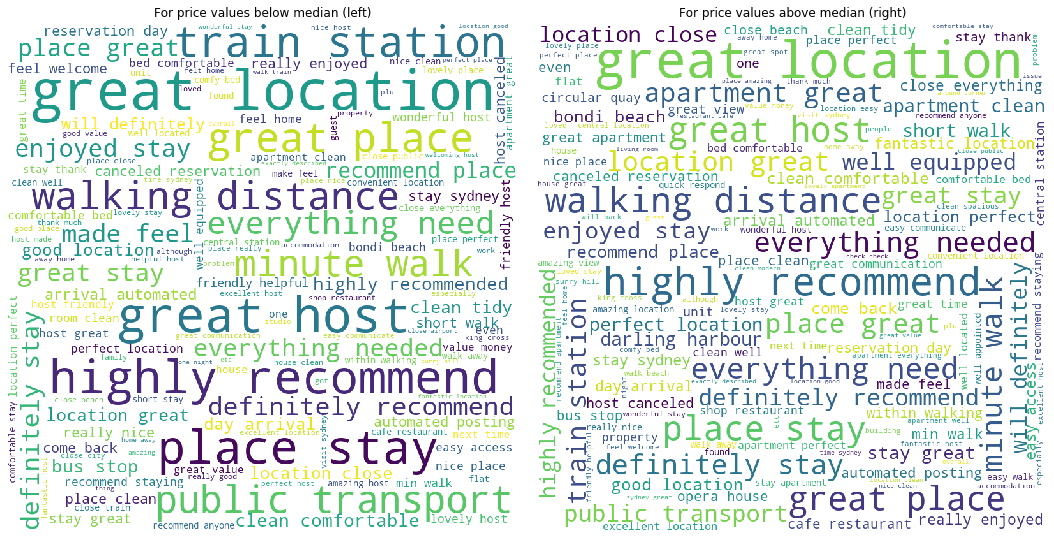

In [96]:
WC_regression(train, 'reviews_clubbed', 'price')

In [97]:
string1 = ''
for i in train[train.price < median(train.price)].reviews_clubbed:
    string1 += i

# print( len(string) )

In [98]:
string2 = ''
for i in test[test.price > median(train.price)].reviews_clubbed:
    string2 += i

# print( len(string) )

In [99]:
## For less than median

less = Counter(string1.split(' ')).most_common(25)

In [100]:
less = pd.DataFrame(less, columns=['word', 'frequency']).set_index('word')

In [101]:
## For more than median
more = Counter(string2.split(' ')).most_common(25)

In [102]:
more = pd.DataFrame(more, columns=['word', 'frequency']).set_index('word')

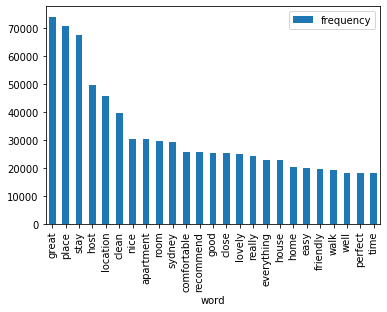

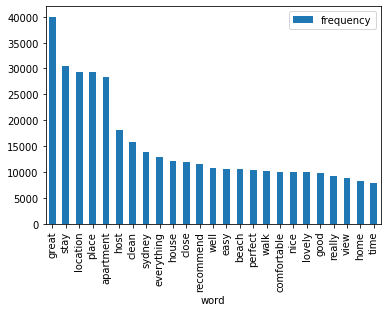

In [103]:
less.plot.bar()
more.plot.bar()
plt.show()

Some words seem to be exclusive to the respective classes whereas some seem to be on both sides. Their frequency differs however.

 
 <br>
 <br>

### Random model:

In [104]:
def evaluate_regression(actual_tr, actual_te, predicted_tr, predicted_te):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    print( 'RMSE on training data : ', mean_squared_error(actual_tr, predicted_tr)**0.5 )
    print( 'RMSE on testing data : ', mean_squared_error(actual_te, predicted_te)**0.5 )
    print('-'*90)
    print( 'MAE on training data : ', mean_absolute_error(actual_tr, predicted_tr) )
    print( 'MAE on testing data : ', mean_absolute_error(actual_te, predicted_te) )
    print('-'*90)
    print( 'R squared on training data : ', r2_score(actual_tr, predicted_tr) )
    print( 'R squared on testing data : ', r2_score(actual_te, predicted_te) )
    print('-'*90)
    print('actual values')
    plt.plot(actual_tr, predicted_tr)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.show()
    print('-'*90)
    plt.plot(actual_te, predicted_te)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.show()

In [105]:
X_train, y_train = train[train.columns.difference(['price'])], train['price']
X_test, y_test = test[test.columns.difference(['price'])], test['price']

X_train.shape, X_test.shape

((17120, 45), (7338, 45))

In [106]:
min_price = train['price'].min()
max_price = train['price'].max()

random_pred_tr = np.random.randint(min_price, max_price, len(X_train))
random_pred_te = np.random.randint(min_price, max_price, len(X_test))

RMSE on training data :  459.5322787214364
RMSE on testing data :  454.42729884692517
------------------------------------------------------------------------------------------
MAE on training data :  378.6068925233645
MAE on testing data :  373.52289452166804
------------------------------------------------------------------------------------------
R squared on training data :  -9.967107718280309
R squared on testing data :  -9.37674141573955
------------------------------------------------------------------------------------------
actual values


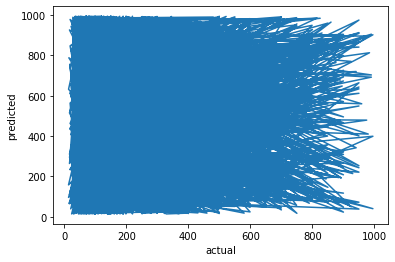

------------------------------------------------------------------------------------------


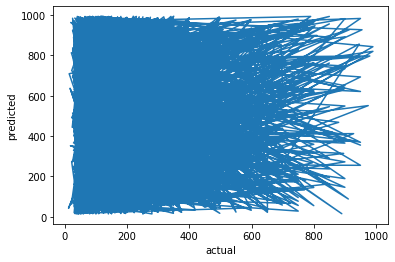

In [107]:
evaluate_regression(y_train, y_test, random_pred_tr, random_pred_te)

Random guessing gives us a terrible model. We will improve on this by using Machine learning.

In [108]:
train.to_csv('train.csv')
test.to_csv('test.csv')